In [34]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 32
num_epochs = 5

z_dimension = 100
num_feature = 56 * 56

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('./datas', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 14 14
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 7 7
        
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
    
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        
        out = out.view(x.size(0), -1)
        return self.fc(out)

In [7]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature)
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 56 56
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
        ) # b 64 56 56
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 32 56 56
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1, stride=2),
            nn.Tanh(),
        ) # b 1 28 28
        
    def forward(self, x):
        out = self.fc(x)
        
        out = out.view(x.size(0), 1, 56, 56)
        out = self.br(out)
        out = self.downsample1(out)
        out = self.downsample2(out)
        out = self.downsample3(out)
        return out

In [8]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4)

In [38]:
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        real_labels = torch.ones(img.size(0), 1).cuda()
        fake_labels = torch.zeros(img.size(0), 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        if (i + 1) % 300 == 0:
            print 'Epoch [{}/{}], Step: {}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean())
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 28, 28).cpu().data
        save_image(real_images, './rl_cnn_img/real_images.png')

    fake_images = fake_img.view(-1, 1, 28, 28).cpu().data
    save_image(fake_images, './rl_cnn_img/fake_images-{}.png'.format(epoch+1))

Epoch [1/5], Step: 9600, d_loss: 0.334150, g_loss: 2.909702, real_scores: 0.900529, fake_scores: 0.101913
Epoch [1/5], Step: 19200, d_loss: 0.197517, g_loss: 1.981453, real_scores: 0.925055, fake_scores: 0.072451
Epoch [1/5], Step: 28800, d_loss: 0.595374, g_loss: 1.973973, real_scores: 0.861711, fake_scores: 0.256981
Epoch [1/5], Step: 38400, d_loss: 0.555540, g_loss: 2.527203, real_scores: 0.847758, fake_scores: 0.160152
Epoch [1/5], Step: 48000, d_loss: 0.626434, g_loss: 2.823772, real_scores: 0.908310, fake_scores: 0.328955
Epoch [1/5], Step: 57600, d_loss: 0.277810, g_loss: 3.012627, real_scores: 0.921219, fake_scores: 0.148798
Epoch [2/5], Step: 9600, d_loss: 0.437052, g_loss: 1.909187, real_scores: 0.861107, fake_scores: 0.178785
Epoch [2/5], Step: 19200, d_loss: 0.442610, g_loss: 3.235762, real_scores: 0.803004, fake_scores: 0.052169
Epoch [2/5], Step: 28800, d_loss: 0.352433, g_loss: 3.098962, real_scores: 0.871268, fake_scores: 0.126655
Epoch [2/5], Step: 38400, d_loss: 0.309

In [39]:
torch.save(d.state_dict(), './ser/discriminator.pkl')
torch.save(g.state_dict(), './ser/generator.pkl')

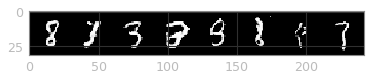

In [54]:
z = torch.randn(8, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()